# Step 3: Data Regression

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ipywidgets as widgets
import plotly.express as px
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


## Recall of data acquisition and data pre-processing

In [7]:

# Loading the dataset
file_path = "dataset/salaries.csv"  
df = pd.read_csv(file_path)

In [8]:
# Part 1: Data Cleaning

# 1. Check for Duplicates
print("\nChecking for Duplicates...")
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Drop duplicates if any
if num_duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicate rows removed.")
else:
    print("No duplicate rows found.")



# 2. Check for Missing Values
print("\nChecking for Missing Values...")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Imputation or Removal of Missing Values
# Strategy: Drop rows or Impute with mean/median
columns_with_null = missing_values[missing_values > 0].index
for column in columns_with_null:
    if df[column].dtype in ['float64', 'int64']:
        df[column].fillna(df[column].median(), inplace=True)
        print(f"Missing values in '{column}' filled with median.")
    else:
        df[column].fillna(df[column].mode()[0], inplace=True)
        print(f"Missing values in '{column}' filled with mode.")

# Final Check for Missing Values
print("\nFinal Check for Missing Values:")
print(df.isnull().sum())

unique_employee_residence = df['employee_residence'].nunique()
print("Number of unique employee residence:", unique_employee_residence)

unique_job_titles = df['job_title'].nunique()
print("Number of unique job titles:", unique_job_titles)

#Check for negative salaries 
negative_salaries = df[df['salary_in_usd'] < 0]
print("Negative Salaries:")
print(negative_salaries)

#Check for data range Check for salaries outside a specific range
salary_range = (1000, 1000000)
out_of_range_salaries = df[(df['salary_in_usd'] < salary_range[0]) | (df['salary_in_usd'] > salary_range[1])]
print("Out of Range Salaries:")
print(out_of_range_salaries)

# Drop the 'salary' column because we will only use salary_in_usd for this analysis
df = df.drop('salary', axis=1)

# Print the updated DataFrame
df.head()

# Mantieni le prime 15 categorie
top_4_categories = df['employee_residence'].value_counts().head(3).index

df['employee_residence'] = df['employee_residence'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['company_location'].value_counts().head(3).index

df['company_location'] = df['company_location'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['salary_currency'].value_counts().head(3).index

df['salary_currency'] = df['salary_currency'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)

# Mantieni le prime 15 categorie
top_4_categories = df['employment_type'].value_counts().head(1).index

df['employment_type'] = df['employment_type'].apply(
    lambda x: x if x in top_4_categories else 'Other'
)



Checking for Duplicates...
Number of duplicate rows: 9333
Duplicate rows removed.

Checking for Missing Values...
Series([], dtype: int64)

Final Check for Missing Values:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64
Number of unique employee residence: 79
Number of unique job titles: 254
Negative Salaries:
Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []
Out of Range Salaries:
Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []



Pipeline without Data Leakage:


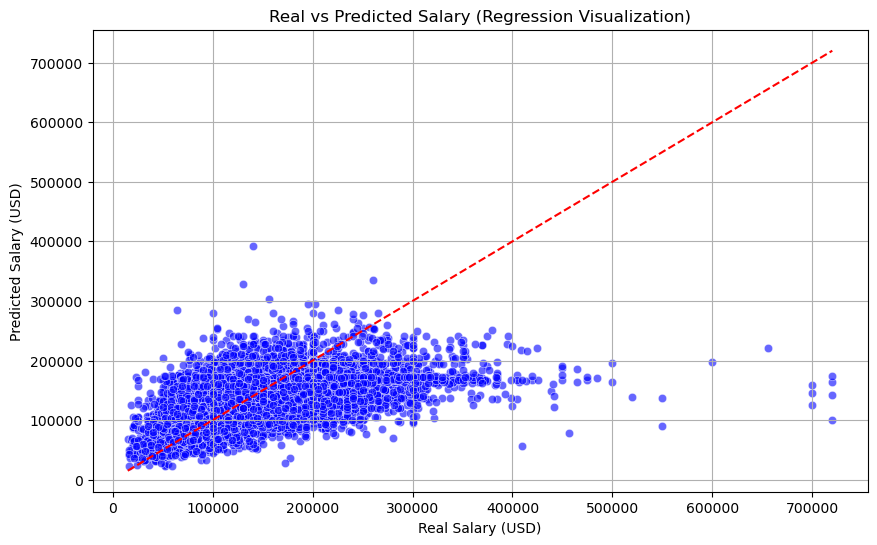


Final Model Evaluation (Without Data Leakage):
{'MAE': 43018.967204679044, 'RMSE': 57973.17517581169, 'R2': 0.21475182497696998}


In [9]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione per valutare il modello
def evaluate_model(y_true, y_pred, apply_expm1=False):
    if apply_expm1:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Definizione delle feature
low_cardinality_features = ['employment_type', 'company_size', 'employee_residence', 'company_location', 'salary_currency']
high_cardinality_features = ['experience_level', 'job_title']
numerical_features = ['work_year', 'remote_ratio']

# Preprocessing pipelines
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, low_cardinality_features),
        ('oe', oe, high_cardinality_features),
        ('scale', scaler, numerical_features)
    ],
    remainder='passthrough'
)

# Inizializzazione K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# Pipeline con Visualizzazione dei Risultati
# ==========================================
print("\nPipeline without Data Leakage:")

y_true_all = []
y_pred_all = []

for train_index, test_index in kf.split(df):
    X = df.drop('salary_in_usd', axis=1)
    y = np.log1p(df['salary_in_usd'])  # Log-transform sul target
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipeline_no_leakage = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])

    pipeline_no_leakage.fit(X_train, y_train)
    y_pred = pipeline_no_leakage.predict(X_test)
    
    y_pred = np.expm1(y_pred)  # Riporta alla scala originale
    y_test = np.expm1(y_test)
    
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Visualizzazione con Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_true_all, y=y_pred_all, alpha=0.6, color='blue')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--')

plt.title("Real vs Predicted Salary (Regression Visualization)")
plt.xlabel("Real Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.grid(True)
plt.show()

# Valutazione Finale del Modello
final_results = evaluate_model(np.array(y_true_all), np.array(y_pred_all))
print("\nFinal Model Evaluation (Without Data Leakage):")
print(final_results)
